DATA PREPROCESSING HAPPENS HERE

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Listing current data on our folder.
import os
print(os.listdir("."))

In [ ]:
import numpy as np #for covering the text to vectors
import pandas as pd# for the dataframe
from music21 import converter, corpus, instrument, midi, note, chord, pitch,stream,roman 
#for analysis of the MIDI files to understand the structure of the file
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
#to plot the analysis
import requests#for webscraping the data
from bs4 import BeautifulSoup #for webscraping the data
# from multiprocessing.dummy import Pool as ThreadPool # Use this when IO is the problem
from multiprocessing import Pool # Use this when CPU-intensive functions are the problem.
import gensim, logging
#use for the WORD2VEC model to find the similarity relationship between the similar chords
import pprint

In [ ]:
# creating a new folder for MIDIs.
midi_path = "MIDIs"
sonic_folder = "sonic"

!rm -r $midi_path
!mkdir $midi_path

#functions to create the folder for the dataset   
def concat_path(path, child):
    return path + "/" + child

def download_midi(midi_url, path):
    !wget $midi_url --directory-prefix $path > download_midi.log

# Downloading a single MIDI file.
sonic_path = concat_path(midi_path, sonic_folder)
download_midi(
    "https://files.khinsider.com/midifiles/genesis/sonic-the-hedgehog/green-hill-zone.mid",
    sonic_path)
    
print(os.listdir(sonic_path))


rm: cannot remove 'MIDIs': No such file or directory
--2021-08-08 11:26:55--  https://files.khinsider.com/midifiles/genesis/sonic-the-hedgehog/green-hill-zone.mid
Resolving files.khinsider.com (files.khinsider.com)... 45.56.66.21
Connecting to files.khinsider.com (files.khinsider.com)|45.56.66.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13034 (13K) [audio/midi]
Saving to: ‘MIDIs/sonic/green-hill-zone.mid’

green-hill-zone.mid 100%[===================>]  12.73K  --.-KB/s    in 0s      

2021-08-08 11:26:56 (138 MB/s) - ‘MIDIs/sonic/green-hill-zone.mid’ saved [13034/13034]

['green-hill-zone.mid']


In [ ]:
#from music21 import converter, corpus, instrument, midi, note, chord, pitch
#function to open the MIDI file and  delete the drum track
def open_midi(midi_path, remove_drums):
   
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)
    
base_midi = open_midi(concat_path(sonic_path, "green-hill-zone.mid"), True)
base_midi

<music21.stream.Score 0x7ffba930d750>

In [ ]:
#function to list the number of tracks
def list_instruments(midi):
    partStream = midi.parts.stream()
    print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        print (p.partName)

list_instruments(base_midi)

List of instruments found on MIDI file:
None
None
None
None
None
None
None
Electric Guitar


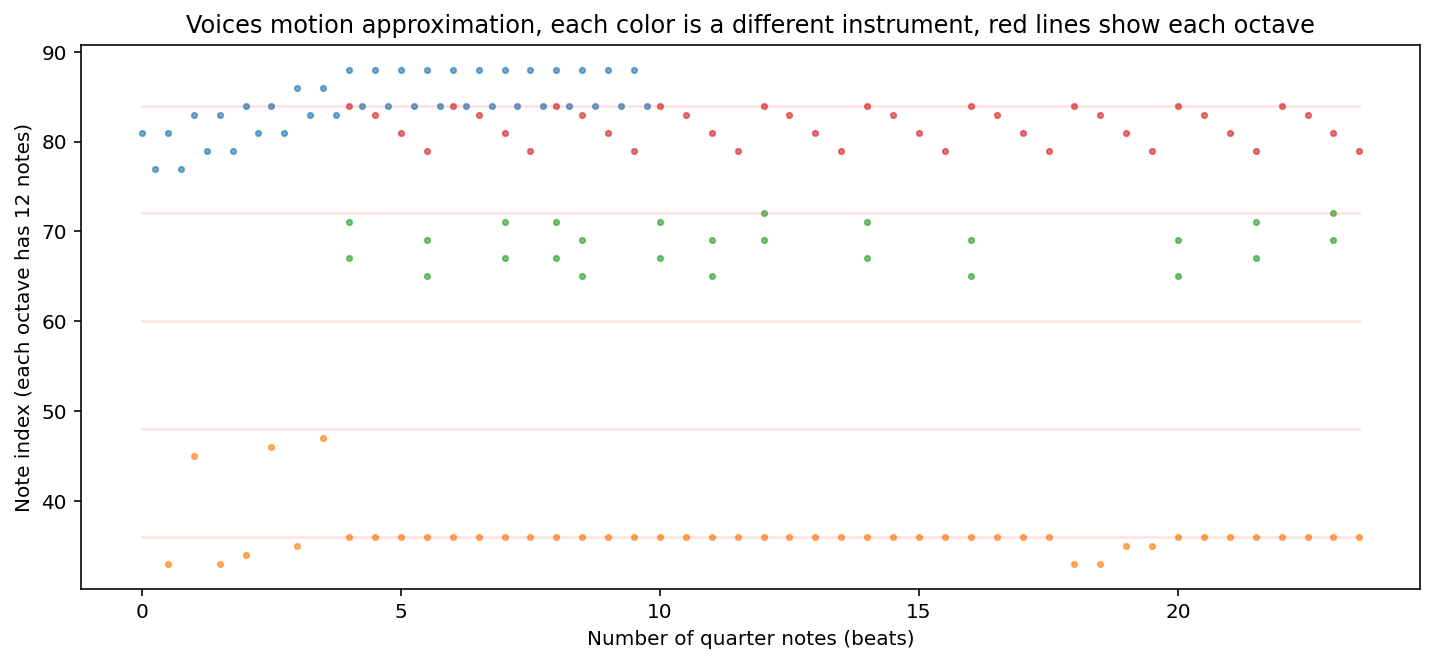

In [ ]:
#import matplotlib.pyplot as plt
#import matplotlib.lines as mlines
# Extract the notes from the file and Visualizing the results
def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element

def print_parts_countour(midi):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    
    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]
        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux
    
    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.show()

# Focusing only on 6 first measures to make it easier to understand.
print_parts_countour(base_midi.measures(0, 6))

In [ ]:
#extracting the other informations like Time Signature, key Signature,Music key confidence
timeSignature = base_midi.getTimeSignatures()[0]
music_analysis = base_midi.analyze('key')
print("Music time signature: {0}/{1}".format(timeSignature.beatCount, timeSignature.denominator))
print("Expected music key: {0}".format(music_analysis))
print("Music key confidence: {0}".format(music_analysis.correlationCoefficient))
print("Other music key alternatives:")
for analysis in music_analysis.alternateInterpretations:
    if (analysis.correlationCoefficient > 0.5):
        print(analysis)


Music time signature: 4/4
Expected music key: a minor
Music key confidence: 0.8770275812674332
Other music key alternatives:
C major
F major
G major
d minor


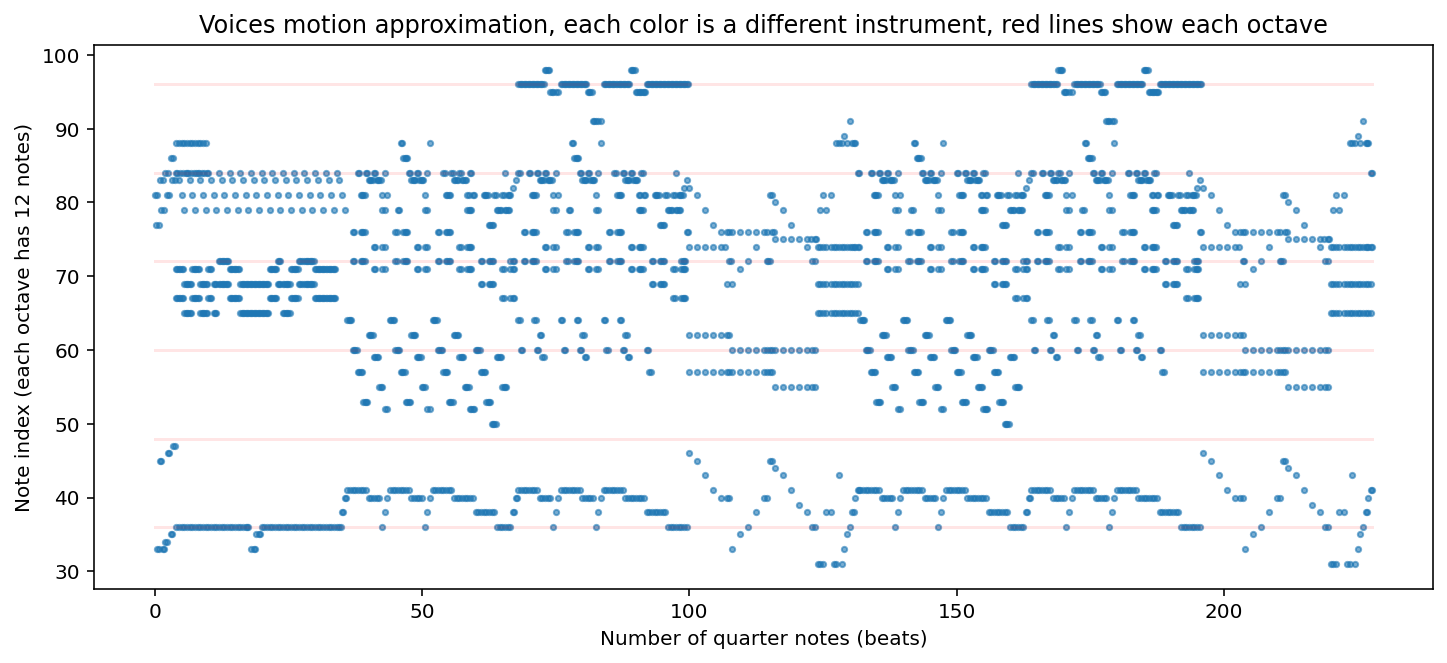

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Instrument >
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=175.0>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord A5>
    {0.25} <music21.chord.Chord F5>
    {0.5} <music21.chord.Chord A1 A5>
    {0.75} <music21.chord.Chord A1 F5>
    {1.0} <music21.chord.Chord A2 B5>
    {1.25} <music21.chord.Chord A2 G5>
    {1.5} <music21.chord.Chord A1 B5>
    {1.75} <music21.chord.Chord A1 G5>
    {2.0} <music21.chord.Chord B-1 C6>
    {2.25} <music21.chord.Chord B-1 A5>
    {2.5} <music21.chord.Chord B-2 C6>
    {2.75} <music21.chord.Chord B-2 A5>
    {3.0} <music21.chord.Chord B1 D6>
    {3.25} <music21.chord.Chord B1 B5>
    {3.5} <music21.chord.Chord B2 D6>
    {3.75} <music21.chord.Chord B2 B5>


In [ ]:
#from music21 import stream

#visualizing the chords extracted
temp_midi_chords = open_midi(
    concat_path(sonic_path, "green-hill-zone.mid"),
    True).chordify()
temp_midi = stream.Score()
temp_midi.insert(0, temp_midi_chords)

# Printing merged tracks.
print_parts_countour(temp_midi)

# Dumping first measure notes
temp_midi_chords.measures(0, 1).show("text")

In [ ]:
#from music21 import roman


#performing harmonic reduction on the Midi file
def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
        
    return bass_note
                
def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret
                
def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
        
        # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        
        # Convert the chord to the functional roman representation
        # to make its information independent of the music key.
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
        
    return ret

harmonic_reduction(base_midi)[0:10]

['ii42', 'III43', '-VI64', 'i42', '-VI', 'i65', 'i65', 'i42', 'III7', 'vi7']

Working on multiple midi files


In [ ]:
#extraction of the remaining dataset from the website by webscraping
#import requests
#from bs4 import BeautifulSoup

def get_file_name(link):
    filename = link.split('/')[::-1][0]
    return filename

def download_file(link, filename):
    mid_file_request = requests.get(link, stream=True)
    if (mid_file_request.status_code != 200):
        raise Exception("Failed to download {0}".format(url))
        
    with open(filename, 'wb+') as saveMidFile:
        saveMidFile.write(mid_file_request.content)

def download_midi_files(url, output_path):
    site_request = requests.get(url)
    if (site_request.status_code != 200):
        raise Exception("Failed to access {0}".format(url))
    
    soup = BeautifulSoup(site_request.content, 'html.parser')
    link_urls = soup.find_all('a')

    for link in link_urls:
        href = link['href']
        if (href.endswith(".mid")):
            file_name = get_file_name(href)
            download_path = concat_path(output_path, file_name)
            midi_request = download_file(href, download_path)

def start_midis_download(folder, url):
    !mkdir $folder # It is fine if this command fails when the directory already exists.
    download_midi_files(url, folder)

target_games = dict()
target_games["sonic1"] = "https://www.khinsider.com/midi/genesis/sonic-the-hedgehog"
target_games["sonic2"] = "https://www.khinsider.com/midi/genesis/sonic-the-hedgehog-2"
target_games["sonic3"] = "https://www.khinsider.com/midi/genesis/sonic-the-hedgehog-3"
target_games["sonicAndKnuckles"] = "https://www.khinsider.com/midi/genesis/sonic-and-knuckles"

for key, value in target_games.items():
    file_path = concat_path(sonic_path, key)
    start_midis_download(file_path, value)


In [ ]:
# from multiprocessing.dummy import Pool as ThreadPool # Use this when IO is the problem
from multiprocessing import Pool # Use this when CPU-intensive functions are the problem.

# the dataframe is being created from the extracted notes which is going to take some time
def process_single_file(midi_param):
    try:
        game_name = midi_param[0]
        midi_path = midi_param[1]
        midi_name = get_file_name(midi_path)
        midi = open_midi(midi_path, True)
        return (
            midi.analyze('key'),
            game_name,
            harmonic_reduction(midi),
            midi_name)
    except Exception as e:
        print("Error on {0}".format(midi_name))
        print(e)
        return None

def create_midi_dataframe(target_games):
    key_signature_column = []
    game_name_column = []
    harmonic_reduction_column = []
    midi_name_column = []
    pool = Pool(8)
    midi_params = []
    for key, value in target_games.items():
        folder_path = concat_path(sonic_path, key)
        for midi_name in os.listdir(folder_path):
            midi_params.append((key, concat_path(folder_path, midi_name)))

    results = pool.map(process_single_file, midi_params)
    for result in results:
        if (result is None):
            continue
            
        key_signature_column.append(result[0])
        game_name_column.append(result[1])
        harmonic_reduction_column.append(result[2])
        midi_name_column.append(result[3])
    
    d = {'midi_name': midi_name_column,
         'game_name': game_name_column,
         'key_signature' : key_signature_column,
         'harmonic_reduction': harmonic_reduction_column}
    return pd.DataFrame(data=d)

sonic_df = create_midi_dataframe(target_games)

Error on final-boss-5-.mid
cannot place element  with start/end 368.0/368.0 within any measures
Error on hydro-city-zone-act-2-speedy-remix-.mid
cannot place element <music21.tempo.MetronomeMark Quarter=125.0> with start/end 404.0/404.0 within any measures
Error on launch-base-electro-nation-mix-.mid
cannot place element  with start/end 208.0/208.0 within any measures
Error on ice-cap-zone-good-future-remix-.mid
cannot place element  with start/end 452.0/452.0 within any measures
Error on final-boss-2-.mid
cannot place element <music21.meter.TimeSignature 4/4> with start/end 268.0/268.0 within any measures


In [ ]:
sonic_df # the data frame is viewed

,midi_name,game_name,key_signature,harmonic_reduction
0,marble-zone-9-.mid,sonic1,d minor,"[ii, ii, ii, III, III53, i, i, ii, III65, ii, ..."
1,spring-yard-zone.mid,sonic1,d minor,"[III42, ii42, v, #iii42, III, ii42, v, #iii42,..."
2,labyrinth-zone-5-.mid,sonic1,C major,"[ii7, I53, iii64, I53, iii64, IV53, vi64, IV53..."
3,marble-zone.mid,sonic1,d minor,"[ii7, ii53, ii53, III, III, i53, i53, ii, ii43..."
4,final-zone-arranged-v1-1-.mid,sonic1,a minor,"[V64, i42, i, vi7, v, i42, i, vi7, iii, -VI64,..."
...,...,...,...,...
446,flying-battery-zone-act-2-8-.mid,sonicAndKnuckles,a minor,"[i, i, i42, i, -VI6, i, i42, i, -VI6, i42, III..."
447,flying-battery-zone-time-travel-remix-.mid,sonicAndKnuckles,f minor,"[iv, V, i, #vi65, V, i, i, V, #vi65, V, i, #vi..."
448,flying-battery-zone-act-1-6-.mid,sonicAndKnuckles,a minor,"[iv, i42, i42, -VI65, #vi, i42, i42, -VI65, #v..."
449,flying-battery-zone-act-1-7-.mid,sonicAndKnuckles,a minor,"[iv, i53, iv43, -VI65, -VI65, i53, iv43, -VI65..."


In [ ]:
writer = pd.ExcelWriter('/content/Sonic_MIDI.xlsx')
sonic_df.to_excel(writer)
writer.save()  #it is saved an excel file to process

In [ ]:
import pandas as pd
import numpy as np

sonic_df = pd.read_excel("/content/Sonic_MIDI.xlsx") #The file is again read to the file for further process

In [ ]:
# import modules & set up logging
import gensim, logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
 
model = gensim.models.Word2Vec(sonic_df["harmonic_reduction"], min_count=2, window=4) #Word2vec model is used to train the dataframe chords
#for identification of similar chords

In [ ]:

def vectorize_harmony(model, harmonic_reduction):
    # Gets the model vector values for each chord from the reduction.
    word_vecs = []
    for word in harmonic_reduction:
        try:
            vec = model[word]
            word_vecs.append(vec)
        except KeyError:
            # Ignore, if the word doesn't exist in the vocabulary
            pass
    
    # Assuming that document vector is the mean of all the word vectors.
    return np.mean(word_vecs, axis=0)

def cosine_similarity(vecA, vecB):
    # Find the similarity between two vectors based on the dot product.
    csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
    if np.isnan(np.sum(csim)):
        return 0
    
    return csim

def calculate_similarity_aux(df, model, source_names=[], target_names=[], threshold=0):
    final_results = []
    for sname in source_names:
        source_harmo = df[df["midi_name"] == sname]["harmonic_reduction"].values[0]
        source_vec = vectorize_harmony(model, source_harmo)
        results = []
        if (len(source_harmo) == 0):
                continue
        for name in target_names:
            target_harmo = df[df["midi_name"] == name]["harmonic_reduction"].values[0]
            if (len(target_harmo) == 0):
                continue
            
            target_vec = vectorize_harmony(model, target_harmo)       
            sim_score = cosine_similarity(source_vec, target_vec)
            if sim_score > threshold:
                results.append({
                    'score' : sim_score,
                    'sourcename' : sname,
                    'targetname' : name,
                    'sourceChord'  : source_harmo,
                    'targetChord'  : target_harmo
                })
                
        # Sort results by score in desc order
        results.sort(key=lambda k : k['score'] , reverse=True)
        final_results.append(results)
    return final_results

def calculate_similarity(df, model, source_sufix, target_sufix, threshold=0):
    source_midi_names = df[df["midi_name"].str.endswith(source_sufix)]["midi_name"].values 
    if (len(source_midi_names) == 0):
        print("Invalid source name")
        return
    
    #source_midi_name = source_midi_names[0]
    
    target_midi_names = df[df["midi_name"].str.endswith(target_sufix)]["midi_name"].values  
    if (len(target_midi_names) == 0):
        print("Invalid target prefix")
        return
    
    return calculate_similarity_aux(df, model, source_midi_names, target_midi_names, threshold)



similarity_records = calculate_similarity(sonic_df, model, "mid", "mid") 

      


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [ ]:
similarity_df = pd.DataFrame()  #using cosine similarity to find the similarity between the source chord and the target chord
len(similarity_records)  #this data is prepared to be run on the other major models for comparison
for record in similarity_records:
    for subrecord in record:
        similarity_df = similarity_df.append(subrecord,ignore_index=True)
        

similarity_df.head()

,score,sourceChord,sourcename,targetChord,targetname
0,1.000000,"['ii', 'ii', 'ii', 'III', 'III53', 'i', 'i', '...",marble-zone-9-.mid,"['ii', 'ii', 'ii', 'III', 'III53', 'i', 'i', '...",marble-zone-9-.mid
1,0.994848,"['ii', 'ii', 'ii', 'III', 'III53', 'i', 'i', '...",marble-zone-9-.mid,"['ii', 'ii53', 'ii', 'ii', 'III', 'III', 'i', ...",marble-zone-8-.mid
2,0.992170,"['ii', 'ii', 'ii', 'III', 'III53', 'i', 'i', '...",marble-zone-9-.mid,"['-', 'I65', 'iv42', 'I6', 'I', 'III53', 'III'...",death-egg-zone-3-.mid
3,0.992129,"['ii', 'ii', 'ii', 'III', 'III53', 'i', 'i', '...",marble-zone-9-.mid,"['-', '#vi42', 'iv43', 'iv43', 'iv43', 'iv43',...",mystic-cave-zone-2-player-3-.mid
4,0.991262,"['ii', 'ii', 'ii', 'III', 'III53', 'i', 'i', '...",marble-zone-9-.mid,"['ii', '-VII65', 'ii', 'ii', 'III', 'III', 'i'...",marble-zone-2-.mid


In [ ]:
writer = pd.ExcelWriter('/content/Sonic_similarity.xlsx')#creating another dataframe for verification
similarity_df.to_excel(writer)
writer.save()

,score,sourcename,targetname
203394,0.403061,act-1-boss-mechanical-onslaught-remix-.mid,ice-cap-zone-act-1-13-.mid
203395,0.397574,act-1-boss-mechanical-onslaught-remix-.mid,ice-cap-zone-act-1-3-.mid
203396,0.396737,act-1-boss-mechanical-onslaught-remix-.mid,ice-cap-zone-act-1-2-.mid
203397,0.396737,act-1-boss-mechanical-onslaught-remix-.mid,ice-cap-zone-act-1.mid
203398,0.358232,act-1-boss-mechanical-onslaught-remix-.mid,launch-base-zone-act-1-3-.mid


In [ ]:
sonic_df = sonic_df.sample(frac=1).reset_index(drop=True)#shuffling the values in the data frame

In [ ]:
writer = pd.ExcelWriter('/content/Sonic_similarity_shuffled.xlsx')#final dataframe is written to excel file
sonic_df.to_excel(writer)
writer.save()